# NYC Bus School Bus Delays
## Identifying Problematic Routes & Days


**Problem** NYC students experience significant school bus delays on already long commutes. The city is trying to incentivize their vendors to arrive on time

**Multi-step solution addressing the factors contributing to delay**
1. Time independant - Route level predictions to identify the route characteristics that are common in frequently delayed routes. 
    1. Understanding the commonalities between frequently delayed routes, a vendor could create a hypothetical route and check to see how it will impact their delay rates
2. Time dependant - Time Series Forecast of the number of delays that will occur tomorrow. 
    1. If a bus vendor could predict that there will be a delay or the length of the delay on any given day they could send 2 buses on the route, start 10 minutes early, service buses more frequently

_________
## Time Independant - Yearly Route Level Delays


In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import time
import re
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer 
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, chi2, SelectFromModel
from sklearn.svm import SVR


---- 
## Import & Clean Data

In [7]:
# Import delays and collapse to route and year level info
delays = pd.read_csv('capstone_data/ny_bus/bus-breakdown-and-delays.csv', low_memory=False, parse_dates=[7,8,16,18]
                     ,infer_datetime_format=True)
delays.columns = delays.columns.str.lower()
delays = delays.rename(
    columns={'number_of_students_on_the_bus':'tot_students'})

delays = delays[delays['school_age_or_prek']=='School-Age'].reset_index()

def displaymatch(match):
    if match is None:
        return None
    return match.group()

# NYC formats the routes they a certain way this drops routes 
# that were not named and regulated by the city
delays['route_number']=delays['route_number'].apply(lambda x: displaymatch(
    re.fullmatch(r"[A-Z]\d\d\d*",str(x),flags=0)))
delays = delays.dropna(subset=['route_number']).reset_index(drop=True)

delays = delays[['school_year','run_type', 'route_number', 'reason', 'schools_serviced', 
                 'occurred_on', 'boro']]
delays['occurred_date']=delays['occurred_on'].apply(
    lambda x: datetime.date(x))

# yearly_delays - sets index to route & year
yearly_delays = pd.DataFrame(delays.groupby(['route_number', 'school_year']).count()['occurred_date'])
yearly_delays = yearly_delays.rename(columns={'occurred_date':'total_delays'})

In [7]:
# Majority of Delays Occur on Morning Trips to schoo
delays['run_type'].value_counts()/len(delays['run_type'])

Special Ed AM Run          0.656246
Special Ed PM Run          0.157710
General Ed AM Run          0.142004
General Ed PM Run          0.033946
Special Ed Field Trip      0.003857
General Ed Field Trip      0.003676
Project Read PM Run        0.002126
Project Read AM Run        0.000411
Project Read Field Trip    0.000012
Name: run_type, dtype: float64

In [9]:
# Quick look at causes of delay - primarily Heavy Traffic
delays['reason'].value_counts()/len(delays['reason'])

Heavy Traffic                  0.605815
Other                          0.124393
Mechanical Problem             0.108189
Won`t Start                    0.048783
Flat Tire                      0.032523
Weather Conditions             0.023366
Late return from Field Trip    0.022646
Problem Run                    0.016125
Accident                       0.009683
Delayed by School              0.008470
Name: reason, dtype: float64

--- 
## Feature Engineering
#### 1. Create route level features that describe the route:
* Origin location city
* Origin location long & latitude
* Includes Routes without delays the origin location and vendor whose bus is delay

In [9]:
# Import and clean table with route identification information
routes = pd.read_csv('capstone_data/routes.csv')
routes.columns = routes.columns.str.lower()

route_table = routes[routes['xcoordinates']>0].reset_index(drop=True)
route_table['garage_city']= route_table['garage_city'].apply(lambda x: x.lower())
route_table['garage_city']= route_table['garage_city'].str.replace(
    'b\'klyn|brooklyn ny|bklyn', 'brooklyn').replace(
    'si','staten island').replace('bron','bronx').replace(
    'pelham', 'pelham manor').replace('l.i.c.', 'long island city')

route_table = route_table[['school_year', 'route_number', 'service_type',
                   'vehicle_typedescription','vendor_code', 'garage_city',
                    'vendor_affiliation','xcoordinates','ycoordinates' ]]
route_table = route_table.rename(columns={'xcoordinates':'garage_xcoordinates',
                                          'ycoordinates':'garage_ycoordinates',
                                         'service_type':'garage_service_type'})
route_table = route_table.set_index(['route_number','school_year'])

# Join the route level descriptive featurs to the delay counts from yearly_delays
all_routes = route_table.join(yearly_delays, how='left', on=['route_number', 'school_year'])
all_routes['total_delays']= all_routes['total_delays'].fillna(0)

In [10]:
delays.head(4)

,school_year,run_type,route_number,reason,schools_serviced,occurred_on,boro,occurred_date
0,2015-2016,Special Ed AM Run,N758,Other,75485,2015-09-02 06:27:00,Nassau County,2015-09-02
1,2015-2016,Special Ed AM Run,L530,Mechanical Problem,21854,2015-09-02 06:24:00,Brooklyn,2015-09-02
2,2015-2016,Special Ed AM Run,K168,Other,18366,2015-09-02 06:45:00,Brooklyn,2015-09-02
3,2015-2016,Special Ed AM Run,K216,Other,21501,2015-09-02 06:55:00,Brooklyn,2015-09-02


In [11]:
print(delays.groupby(by='school_year')['occurred_date'].min())
print(delays.groupby(by='school_year')['occurred_date'].max())

school_year
2015-2016    2015-09-01
2016-2017    2016-07-01
2017-2018    2017-07-03
2018-2019    2018-09-04
2019-2020    2020-03-30
Name: occurred_date, dtype: object
school_year
2015-2016    2016-06-30
2016-2017    2017-06-29
2017-2018    2018-06-28
2018-2019    2019-01-18
2019-2020    2020-03-30
Name: occurred_date, dtype: object


In [12]:
all_routes.head(4)

,,garage_service_type,vehicle_typedescription,vendor_code,garage_city,vendor_affiliation,garage_xcoordinates,garage_ycoordinates,total_delays
route_number,school_year,,,,,,,,
C911,2015-2016,D2D,Non-Wheelchair Accessible Alternative (NWC),VN,pelham manor,VAN TRANS LLC (B2192),1.034574e+06,265547.592642,2.0
J499,2015-2016,D2D,Mini-Wagon,RV,brooklyn,"RELIANT TRANS, INC. (B2321)",1.000787e+06,204481.000000,13.0
J500,2015-2016,D2D,Non-Wheelchair Accessible Alternative (NWC),HT,brooklyn,"THOMAS BUSES, INC. (B2321)",9.834390e+05,148884.000000,3.0
J501,2015-2016,D2D,Non-Wheelchair Accessible Alternative (NWC),HT,brooklyn,"THOMAS BUSES, INC. (B2321)",9.834390e+05,148884.000000,2.0


#### 2. School Level Features
* Clean school information
* Join school level info to routes so they can be aggregated on route level (some routes have more than 1 school)
* Count number of schools in each route
* Count number of cities visited in each route

In [13]:
# Import Metadata
destinations = pd.read_csv('capstone_data/bus_stops.csv')
destinations.columns = destinations.columns.str.lower()

# Import key to connect school data to route
route_key = pd.read_csv('capstone_data/routes_by_site.csv')
route_key.columns = route_key.columns.str.lower()
#route_key['route_number']=route_key['route_number'].apply(lambda x: re.findall(r"[A-Z]\d\d\d*",x)[0])

In [14]:
# create a school level table and create features describing the schools on the route
df_schools= destinations[(
    destinations['stop_to_school_service']=='Yes')|(
    destinations['door_to_door_service']=='Yes')].reset_index(drop=True)
df_schools= df_schools[df_schools['site_type']=='School'].reset_index(drop=True)
df_schools= df_schools[['school_year', 'opt_code', 'name', 'affiliation',
       'city', 'longitude', 'latitude']]

# change opt_code datatype so that it is compatible with the route_key
df_schools['opt_code'] = df_schools['opt_code'].astype('int')
df_schools['city'] = df_schools['city'].str.lower()
df_schools['affiliation']= df_schools['affiliation'].str.lower().str.replace('-','_').str.replace(' ', '_')

df_schools = df_schools.rename(columns={'city':'school_city', 
                           'affiliation':'school_affiliation',
                           'name':'school_name', 
                           'longitude':'school_longitude',
                           'latitude':'school_latitude'})
# rename to keep track of     
route_level_schools = route_key.merge(df_schools, how='inner',
                                      left_on=['opt_code','school_year'], 
                                      right_on=['opt_code', 'school_year'])


In [17]:
# city_count
route_city_count = pd.DataFrame(route_level_schools.groupby(['route_number', 'school_year'])['school_city'].nunique())
route_city_count.columns = ['route_city_count']

# school_count
school_count = pd.DataFrame(route_level_schools.groupby(['route_number', 'school_year'])['opt_code'].nunique())
school_count.columns = ['route_tot_opt_codes']

# school long & lat
school_long_lat = pd.DataFrame(route_level_schools.groupby(['route_number', 'school_year']).agg(
{'school_longitude':'max', 'school_latitude':'max'}))

# school dummies
school_dummies = pd.get_dummies(route_level_schools, columns=['school_affiliation', 'school_city'])
school_dummies = school_dummies.groupby(
    ['route_number','school_year']).sum().loc[:,'school_affiliation_charter':]

school_features = route_city_count.join(school_count, how='inner').join(
                school_long_lat, how='inner').join(school_dummies, how='inner')

#### 4. Calculate relative distance schools are to a reference location

In [18]:
# set comparison location via lat and long (this one is empire state building)
route_level_schools['ref_lat'] = 40.748817
route_level_schools['ref_long'] = -73.985428

# Subtract schools lat & long coordinates from reference building
route_level_schools['lat_distance'] = route_level_schools['ref_lat']- route_level_schools['school_latitude']
route_level_schools['long_distance'] = route_level_schools['ref_long']- route_level_schools['school_longitude']

# distance_mean
distance_mean = pd.DataFrame(route_level_schools.groupby(
    ['route_number', 'school_year'])[['lat_distance','long_distance']].mean())
distance_mean.columns= ['lat_distance_mean', 'long_distance_mean']

____
#### 5. Bring all Features together in 1 DataFrame

In [19]:
# Bring freatures together into 1 dataframe
route_all_cat = all_routes.join(school_features, how='inner').join(
                distance_mean, how='inner')

# Mix up order
route_all_cat = route_all_cat.sample(frac=1)

# Add dummies
route_all = pd.get_dummies(route_all_cat, columns=[
    'vehicle_typedescription','garage_city','garage_service_type'])

In [28]:
df_schools.school_city.value_counts()/len(df_schools.school_city)

brooklyn         0.305465
bronx            0.207474
queens           0.205302
manhattan        0.193902
staten island    0.056822
westchester      0.013301
nassau           0.011129
new jersey       0.005429
connecticut      0.001176
Name: school_city, dtype: float64

In [33]:
route_all[school_city_features].mean().sort_values(ascending=False)

school_city_brooklyn         0.741528
school_city_queens           0.540457
school_city_bronx            0.470657
school_city_manhattan        0.381152
school_city_staten island    0.174679
school_city_westchester      0.037696
school_city_nassau           0.018158
school_city_new jersey       0.008615
school_city_connecticut      0.000904
dtype: float64

In [25]:
route_all.garage_city.value_counts()/len(route_all.garage_city)

brooklyn            0.374941
bronx               0.288624
jamaica             0.103189
staten island       0.091742
ozone park          0.048429
pelham manor        0.027392
queens              0.019895
astoria             0.017991
mount vernon        0.017206
yonkers             0.004403
oceanside           0.003284
whitestone          0.002356
elmont              0.000452
long island city    0.000071
bayshore            0.000024
Name: garage_city, dtype: float64

### Feature Groupings for organization purposes
For ease of setting up train and test sets

In [21]:
school_affiliation_agg = ['school_affiliation_charter', 'school_affiliation_christian',
       'school_affiliation_non_nyc_public', 'school_affiliation_nonsectarian',
       'school_affiliation_other_religion', 'school_affiliation_parochial',
       'school_affiliation_public', 'school_affiliation_yeshiva']

school_city_features = ['school_city_bronx','school_city_brooklyn', 'school_city_connecticut', 'school_city_manhattan', 
                        'school_city_nassau','school_city_new jersey', 'school_city_queens', 'school_city_staten island',
                        'school_city_westchester']

vehicle_type_features = ['vehicle_typedescription_Hydraulic Lift',
       'vehicle_typedescription_Mini-Wagon',
       'vehicle_typedescription_Non-Wheelchair Accessible Alternative (NWC)',
       'vehicle_typedescription_Ramp-Wagon',
       'vehicle_typedescription_Standard Bus (GE)',
       'vehicle_typedescription_Standard Bus (SE)',
       'vehicle_typedescription_Type A or B Flex Vehicle',
       'vehicle_typedescription_Type C or D Flex',
       'vehicle_typedescription_Wheelchair Accessible Alternative (WC)']

garage_city_features = ['garage_city_astoria', 'garage_city_bayshore', 'garage_city_bronx',
       'garage_city_brooklyn', 'garage_city_elmont', 'garage_city_jamaica',
       'garage_city_long island city', 'garage_city_mount vernon',
       'garage_city_oceanside', 'garage_city_ozone park',
       'garage_city_pelham manor', 'garage_city_queens',
       'garage_city_staten island', 'garage_city_whitestone',
       'garage_city_yonkers']

service_type_features = ['garage_service_type_D2D', 'garage_service_type_S2S AM',
       'garage_service_type_S2S PM']


## Understanding the problem - what does our target variable look like?

The below histogram has a long right tail. Most bus routes will experience about 2 delays a year which would not be disruptive. For the unlucky students that have 30+ delays a year this would be a very disruptive problem. This suggests 1. that the buses can be on time and 2. the number of changes needed to drastically improve the quality for students is not outside the realm of possibility

Standard Deviation: 13.35
Min: 0.00
Max: 322.00


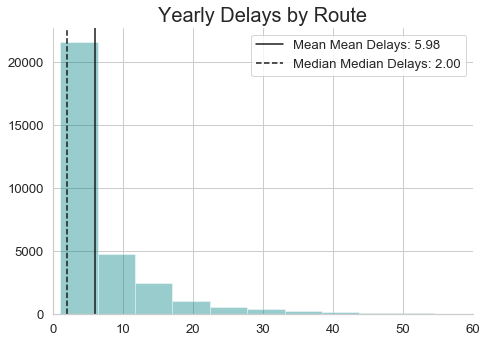

In [23]:
# Set Style of Histogram
mean = route_all['total_delays'].mean()
median = route_all['total_delays'].median()
stdev = route_all['total_delays'].std()

plt.figure(figsize=(7,5))
sns.set(font_scale=1.2,style='whitegrid' )
ax = sns.distplot(yearly_delays, kde=False, color='teal', bins=60)
    
# Set Label Names and Label Font
ax.set(xlabel='', ylabel='', xlim=(0,60))
ax.set_title('Yearly Delays by Route', fontsize=20)
    
# Add Vertical Lines and Legend
axv1 = ax.axvline(mean, label='Mean %s: %4.2f'%('Mean Delays', mean), color='k')
axv2 = ax.axvline(median, label='Median %s: %4.2f'%('Median Delays', median), linestyle='--', color='k')
ax.legend()
    
# Finalize the plot
sns.despine(trim=True)
plt.tight_layout(h_pad=2)
print('Standard Deviation: %.2f'%route_all['total_delays'].std())
print('Min: %.2f'%route_all['total_delays'].min())
print('Max: %.2f'%route_all['total_delays'].max())

____
## Modelling Route Level Delays

### Define X and y for Modelling

In [22]:
# Simplify dataframe to features we want to test
X = route_all[['garage_xcoordinates','garage_ycoordinates',  'route_city_count',
               'route_tot_opt_codes', 'school_longitude', 'school_latitude']+ 
               school_affiliation_agg + school_city_features + vehicle_type_features+ garage_city_features]

y = route_all['total_delays']

### 1. Linear Regression
Starting out with a straightforward, cross-validated linear regression. The R2 are on the low end but were slightly improved with scaling and 

In [37]:
# Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', LinearRegression())
])

parameters = {
    'threshold__threshold': (.0005,.0008, .0002),
    'features__k': ('all', 20, 10)
}

grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='r2')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 0.113
Best parameters: 
{'features__k': 20, 'threshold__threshold': 0.0005}


In [40]:
# Linear Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', LinearRegression())
])

parameters = {
    'threshold__threshold': (.0005,),
    'features__k': (20,)
}

grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*-1)))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 12.571
Best parameters: 
{'features__k': 20, 'threshold__threshold': 0.0005}


### 2. Ridge Regression

In [41]:
# Ridge Alpha prefers higher numbers, started with .001 and gradually worked
# up to 5, No R2 benefit from these increases though
# Also tried MinMaxScaler, StandardScaler, Normilzer(0.016)
pipeline = Pipeline([
   # ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', Ridge())
])

parameters = {
    'threshold__threshold': (.0005,.001,.0001),
    'features__k': ('all',30,),
    'clf__alpha': (5, 10,15),
}

grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='r2')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 0.119
Best parameters: 
{'clf__alpha': 10, 'features__k': 'all', 'threshold__threshold': 0.0005}


In [43]:
# Ridge Alpha prefers higher numbers, started with .001 and gradually worked
# up to 5, No R2 benefit from these increases though
# Also tried MinMaxScaler, StandardScaler, Normilzer(0.016)
pipeline = Pipeline([
   # ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', Ridge())
])

parameters = {
    'threshold__threshold': (.0005,),
    'features__k': ('all',),
    'clf__alpha': (10,),
}

grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 12.527
Best parameters: 
{'clf__alpha': 10, 'features__k': 'all', 'threshold__threshold': 0.0005}


### 3. Lasso Regression

In [46]:
# Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', Lasso())
])

parameters = {
    'threshold__threshold': (.0005,.001),
    'features__k': ('all',30),
    'clf__alpha': (.01,.008,),
}

grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='r2')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 0.119
Best parameters: 
{'clf__alpha': 0.008, 'features__k': 'all', 'threshold__threshold': 0.0005}


In [47]:
# Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', Lasso())
])

parameters = {
    'threshold__threshold': (.0005,),
    'features__k': ('all',),
    'clf__alpha': (.008,),
}

grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 12.527
Best parameters: 
{'clf__alpha': 0.008, 'features__k': 'all', 'threshold__threshold': 0.0005}


### 4. Random Forest

In [22]:
# random forest + test features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', RandomForestRegressor(n_jobs=-1, random_state=5))
])

parameters = {
    'threshold__threshold': (.008,), #.008,.01,
    #'features__k': ( 'all',30,20,),
    'clf__max_depth': (7,9,),#7,9,,11
    'clf__n_estimators': (70,100,)#70, 100, 50, 150
}
    
grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='r2')
grid_search.fit(X, y)

print('Best score: %.3f'%(grid_search.best_score_))
print('Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 0.233
Best parameters: 
{'clf__max_depth': 7, 'clf__n_estimators': 70, 'threshold__threshold': 0.008}


In [69]:
# random forest + test features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', RandomForestRegressor(n_jobs=-1, random_state=5))
])

parameters = {
    'threshold__threshold': (.008,), #.008
    'features__k': ( 'all',),
    'clf__max_depth': (7,),#7
    'clf__n_estimators': (70,)#20
}
    
grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 11.691
Best parameters: 
{'clf__max_depth': 7, 'clf__n_estimators': 70, 'features__k': 'all', 'threshold__threshold': 0.008}


### 5. Gradient Boost

In [136]:
# gradient boost
# fiddling with learning rate
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', GradientBoostingRegressor(random_state=5))
])

parameters = {
    'threshold__threshold': (.01,.008),
    'features__k': ('all',30,),
    'clf__max_depth': (7,5,3),
    'clf__n_estimators': (150,100,80),
    'clf__learning_rate': (0.03,),#0.01,0.05),
    'clf__subsample':(0.3,)
}
 
                                            
grid_search = GridSearchCV(pipeline, parameters, 
                           cv=3, scoring='r2', refit=True)
grid_search.fit(X,y)

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 0.237
Best parameters: 
{'clf__learning_rate': 0.03, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__subsample': 0.3, 'features__k': 30, 'threshold__threshold': 0.01}


In [137]:
# gradient boost
# fiddling with learning rate
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', GradientBoostingRegressor(random_state=5))
])

parameters = {
    'threshold__threshold': (.01,),
    'features__k': (30,),
    'clf__max_depth': (5,),
    'clf__n_estimators': (100,),
    'clf__learning_rate': (0.03,),#0.01,0.05),
    'clf__subsample':(0.3,)
}
 
                                            
grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(np.sqrt(grid_search.best_score_*(-1))))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 11.656
Best parameters: 
{'clf__learning_rate': 0.03, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__subsample': 0.3, 'features__k': 30, 'threshold__threshold': 0.01}


_____
## Feature Importance - Random Forest

In [147]:
df_support =pd.DataFrame({
    'features':X.columns, 
    'support':grid_search.best_estimator_.named_steps['features'].get_support()
    })

#df_support[df_support['support']==True].features.reset_index(drop=True)

# Print feature importance:
importance = pd.DataFrame(data={'features':df_support[df_support['support']==True].features.reset_index(drop=True), 
                                'feature_importance':grid_search.best_estimator_.named_steps['clf'].feature_importances_})
importance = importance.sort_values(by='feature_importance', ascending=False).reset_index(drop=True)

importance['features'] = importance['features'].str.lower().str.replace(
    'vehicle_typedescription_', '').replace('route_tot_opt_codes','school_count')

In [70]:
cross_val_neg_mean_sqared_error = cross_val_score(grid_search,X,y,scoring='neg_mean_squared_error')

In [73]:
print(np.mean(np.sqrt(cross_val_neg_mean_sqared_error*(-1))))
print(np.std(np.sqrt(cross_val_neg_mean_sqared_error*(-1))))

11.681494396924526
0.4792388495797186


In [68]:
np.mean([0.21879596, 0.22191017, 0.23897901])

0.22656171333333333

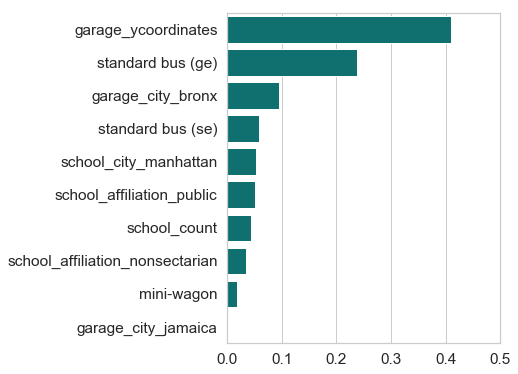

In [107]:
# Random Forest Features
plt.figure(figsize=(7.5,5.5))
sns.set(font_scale=1.4, style='whitegrid')
ax = sns.barplot(x="feature_importance",
                 y='features', color='teal', data=importance)
ax.set(xlabel='',
       ylabel='',
       xlim=(0.0, 0.5)
      )
ax.set_title('', fontsize=15)

plt.tight_layout(h_pad=4,w_pad=4)



### Visualizing the winning model

In [81]:
route_subset['predicted_delays'] = grid_search.best_estimator_.named_steps['clf'].predict(route_subset)

In [23]:
# random forest + test features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('threshold', VarianceThreshold()),
    ('features', SelectKBest(f_regression)),
    ('clf', RandomForestRegressor(n_jobs=-1, random_state=5))
])

parameters = {
    'threshold__threshold': (.008,), #.002
    #'features__k': (30,),
    'clf__max_depth': (9,),#7
    'clf__n_estimators': (100,)#20
}
    
grid_search = GridSearchCV(pipeline, parameters,
                           refit=True, scoring='r2')
grid_search.fit(X, y)

print( 'Best score: %.3f'%(grid_search.best_score_))
print( 'Best parameters: \n{}'.format(grid_search.best_params_))

Best score: 0.227
Best parameters: 
{'clf__max_depth': 9, 'clf__n_estimators': 100, 'threshold__threshold': 0.008}


In [24]:
predict_y = grid_search.best_estimator_.predict(X)

outcome = pd.DataFrame(data={'predictions':predict_y, 'actual_delays':y}, 
                       columns=['predictions','actual_delays'])

outcome['residuals'] = outcome['predictions']-outcome['actual_delays']
outcome_cat = outcome.join(route_all_cat, how='left')

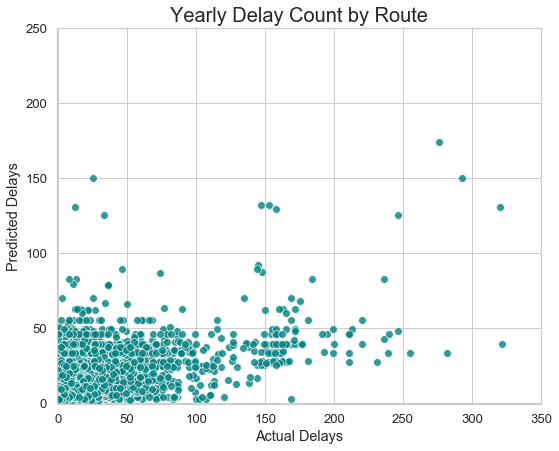

In [74]:
# Set Style of Histogram
plt.figure(figsize=(8,6.5))
sns.set(font_scale=1.2,style='whitegrid' )
ax = sns.scatterplot(data=outcome_cat, 
                     y='predictions', s=60,
                     x='actual_delays', color = 'teal', alpha=.8)
    
# Set Label Names and Label Font
ax.set(ylabel='Predicted Delays', 
    xlabel='Actual Delays',
       ylim=(-1, 250),xlim=(-1, 350),)
ax.set_title('Yearly Delay Count by Route', fontsize=20)
    

plt.tight_layout()
    

________
## Time Dependant - Time Series Forecast Predicting the Number of Delays Tomorrow

Notes on School Scheduling
* 2015-2016: 2015-09-09 to 2016-06-28
* 2016-2017: 2016-09-08 to 2017-06-28
* 2017-2018: 2017-09-07 to 2018-06-26

## Cleaning Data
#### 1. Import Data & Restrict to Relevant Routes

In [24]:
# Import delays
delays = pd.read_csv('capstone_data/ny_bus/bus-breakdown-and-delays.csv', low_memory=False, parse_dates=[7,8,16,18]
                     ,infer_datetime_format=True)
delays.columns = delays.columns.str.lower()
delays = delays[delays['school_age_or_prek']=='School-Age']

delays = delays[['school_year', 'run_type', 'reason', 'route_number', 'occurred_on']].reset_index(drop=True)
delays['occurred_date']=delays['occurred_on'].apply(lambda x: datetime.date(x))

# Create field rounded to the date
delays_by_day = pd.DataFrame(data=delays.groupby(by=['occurred_date']).agg(
    {'route_number':'count'})).rename(columns={'route_number':'delay_count'})

# 2015-2018
date_index = pd.date_range(start='2015-09-01', end='2018-06-26', freq='B')
df_daily = pd.DataFrame(index=date_index).join(delays_by_day, how='left').fillna(0)
df_daily['day'] = df_daily.index.day_name()
df_daily['month'] = df_daily.index.month_name()
df_daily['year'] = df_daily.index.year

# 2017 - 2018
grid_search_daily = df_daily.loc['2017-09-01':,:].copy()

Summarizing daily delays by school year we find that the average number of delays is steadily increasing as well as the standard deviation in the number of daily delays. Therefore delays are becoming more numerous and more eratic year-over-year.

In [25]:
delays_by_schoolyear = pd.DataFrame(data=delays.groupby(by=['school_year','occurred_date']).agg(
    {'route_number':'count'})).rename(columns={'route_number':'delay_count'}).reset_index(['school_year'],drop=False)
delays_by_schoolyear.groupby('school_year').describe().loc['2015-2016':'2017-2018',:].T.round()

school_year        2015-2016  2016-2017  2017-2018
delay_count count      208.0      246.0      232.0
            mean       262.0      290.0      343.0
            std        140.0      170.0      186.0
            min          1.0        1.0        1.0
            25%        220.0      154.0      232.0
            50%        284.0      322.0      401.0
            75%        321.0      399.0      458.0
            max       1099.0      836.0      779.0

-----
## Visualizing Seasonality


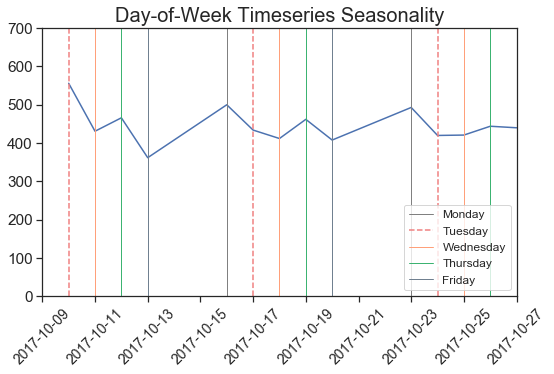

In [26]:

df_month = grid_search_daily.loc['2017-10-10':'2017-10-27']
plt.figure(figsize=(8,5.5))
sns.set(font_scale=1.4, style='ticks')
# fig = plt.figure(figsize = (12,7))
#sns.set(font_scale=1.4,style='ticks')

ax = sns.lineplot(data=df_month, y='delay_count', x=df_month.index, )
ax.tick_params(axis=df_month.index.day, which="minor", bottom=True)
ax.set_title('Day-of-Week Timeseries Seasonality', fontsize=20)
ax.set(ylim=(0,700), xlim=('2017-10-09','2017-10-27'),
      xlabel='', ylabel='')

plt.setp(ax.get_xticklabels(), rotation=45, fontsize=14)
ax.axvline(x='2017-10-16',c='grey', linewidth=1, label='Monday')
ax.axvline(x='2017-10-23',c='grey', linewidth=1)


ax.axvline(x='2017-10-10',linestyle='--',c='lightcoral', linewidth=1.5, label='Tuesday')
ax.axvline(x='2017-10-17',linestyle='--',c='lightcoral', linewidth=1.5)
ax.axvline(x='2017-10-24',linestyle='--',c='lightcoral', linewidth=1.5)

ax.axvline(x='2017-10-11',c='lightsalmon', linewidth=1, label='Wednesday')
ax.axvline(x='2017-10-18',c='lightsalmon', linewidth=1)
ax.axvline(x='2017-10-25',c='lightsalmon', linewidth=1)

ax.axvline(x='2017-10-12',c='mediumseagreen', linewidth=1, label='Thursday')
ax.axvline(x='2017-10-19',c='mediumseagreen', linewidth=1)
ax.axvline(x='2017-10-26',c='mediumseagreen', linewidth=1)

ax.axvline(x='2017-10-13',c='slategrey', linewidth=1, label='Friday')
ax.axvline(x='2017-10-20',c='slategrey', linewidth=1)
ax.axvline(x='2017-10-27',c='slategrey', linewidth=1)

plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()

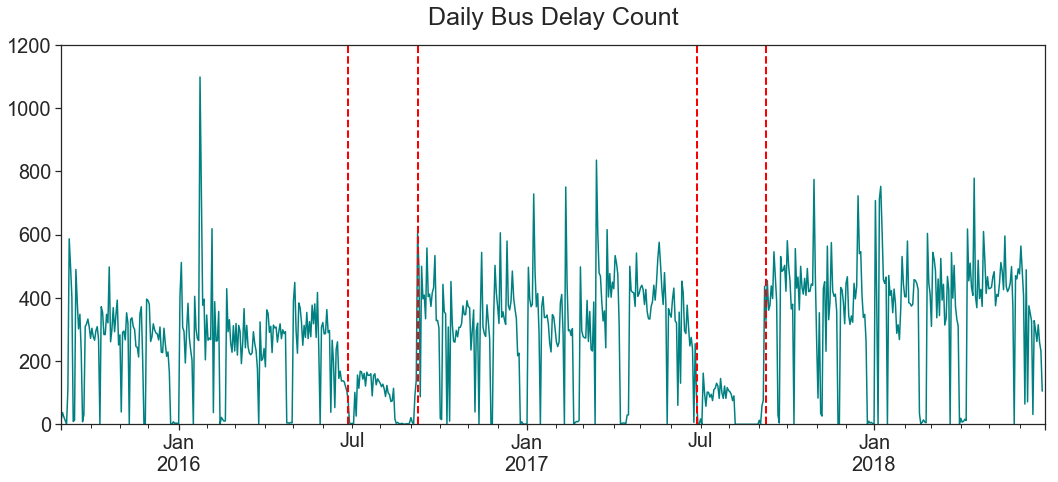

In [27]:
df_left = pd.DataFrame(index=date_index).join(delays_by_day, how='left').fillna(0)
fig = plt.figure(figsize = (15,7))

# add the x-axis and the y-axis to the plot
ax = df_left['delay_count'].plot(
        color = 'teal',fontsize=20)

# set title and labels for axes
ax.set_title(label="Daily Bus Delay Count",fontsize=25, pad=20)
ax.set_ylim(0,1200)
ax.set_xlim('2015-09-01', '2018-06-28')

ax.axvline(x='2016-06-28',linestyle='--',c='red', linewidth=2)
ax.axvline(x='2016-09-08',linestyle='--',c='red', linewidth=2)
ax.axvline(x='2017-06-28',linestyle='--',c='red', linewidth=2)
ax.axvline(x='2017-09-08',linestyle='--',c='red', linewidth=2)
#plt.setp(ax.get_xticklabels(), rotation=45)
plt.tight_layout(h_pad=2, w_pad=2)

Looking at delay counts by day-of-week, Mondays have the highest average delays followed by Thursdays. Incorporating week level seasonality should help with time-series predictions.

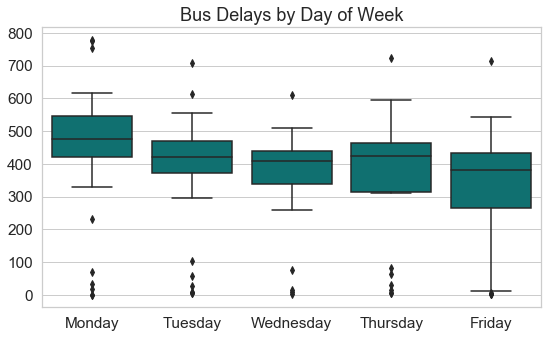

In [64]:
# Day of Week delays
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
plt.figure(figsize=(8,5))
sns.set(font_scale=1.4,style='whitegrid' )

ax = sns.boxplot(data=grid_search_daily, x='day', y='delay_count', 
                 color='teal',order=order)
ax.set(xlabel='', 
       ylabel='')
ax.set_xticklabels(labels, rotation=0)
ax.set_title('Bus Delays by Day of Week', fontsize=18)
plt.tight_layout(h_pad=2, w_pad=2)

Average daily delay count and standard deviation widely vary by month. Future analysis would benefit by incorporating year-over-year seasonality.

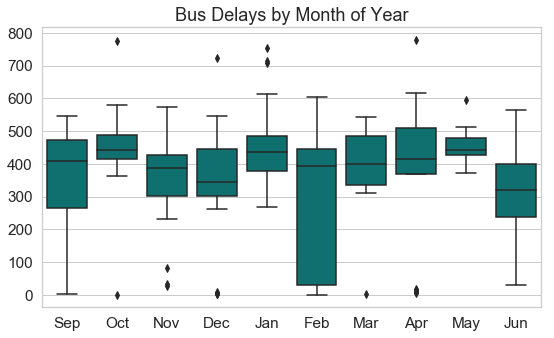

In [63]:
df_daily = pd.DataFrame(index=date_index).join(delays_by_day, how='inner').fillna(0)
df_daily['day'] = df_daily.index.day_name()
df_daily['month'] = df_daily.index.month_name()
df_daily['year'] = df_daily.index.year

# 2017 - 2018
grid_search_daily = df_daily.loc['2017-09-01':,:].copy()

# Month of Year Delay Boxplot
order = ['September', 'October', 'November', 'December', 'January', 'February', 
         'March', 'April', 'May', 'June']
labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 
          'Mar', 'Apr', 'May', 'Jun']
plt.figure(figsize=(8,5))
sns.set(font_scale=1.4,style='whitegrid' )

ax = sns.boxplot(data=grid_search_daily, x='month', y='delay_count', 
                 color='teal',order=order)
ax.set(xlabel='', ylabel='')
ax.set_xticklabels(labels)
ax.set_title('Bus Delays by Month of Year', fontsize=18)
plt.tight_layout(h_pad=2, w_pad=2)

----
## ACF & PACF looking to identify order of lags in ARIMA/SARIMA


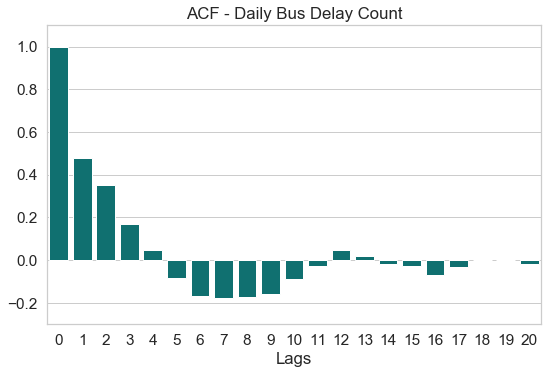

In [181]:
# Examine ACF looking for seasonal patterns trying to identify cycle length
x_acf = pd.DataFrame(acf(grid_search_daily.delay_count, nlags = 20))

plt.figure(figsize=(8,5.5))
sns.set(font_scale=1.4, style='whitegrid')

ax = sns.barplot(data=x_acf, x=x_acf.index, y=0,
                 color='teal')
ax.set(xlabel='Lags', ylabel='', ylim=(-.3,1.1), xlim=(-0.5,20.5))
ax.set_title(label='ACF - Daily Bus Delay Count')

plt.tight_layout(h_pad=2, w_pad=2)

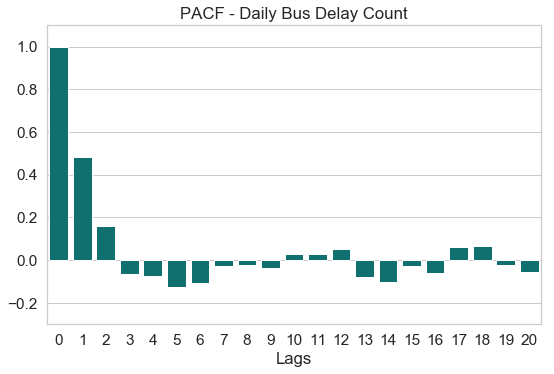

In [215]:
# Examine PACF looking for seasonal patterns trying to identify cycle length
x_pacf = pd.DataFrame(pacf(grid_search_daily.delay_count, nlags = 20))

plt.figure(figsize=(8,5.5))
sns.set(font_scale=1.4, style='whitegrid')

ax = sns.barplot(data=x_pacf, x=x_acf.index, y=0,
                 color='teal')
ax.set(xlabel='Lags', ylabel='', ylim=(-.3,1.1), xlim=(-0.5,20.5))
ax.set_title(label='PACF - Daily Bus Delay Count')

plt.tight_layout(h_pad=2, w_pad=2)

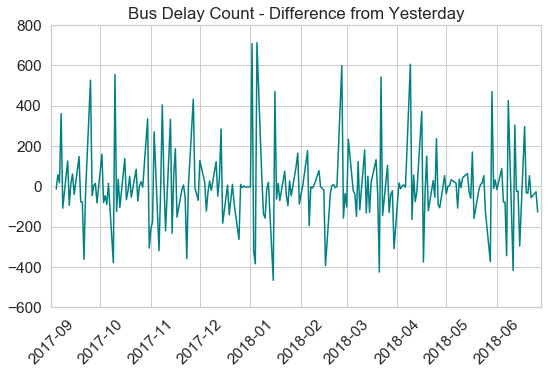

In [364]:
grid_search_daily['diff_1'] = grid_search_daily.delay_count - grid_search_daily.delay_count.shift()
time_shift = pd.DataFrame(grid_search_daily.iloc[1:,4])

plt.figure(figsize=(8,5.5))
sns.set(font_scale=1.4, style='whitegrid')

ax = sns.lineplot(data=time_shift, x=time_shift.index, y='diff_1',
                 color='teal')
ax.set(xlabel='', ylabel='', 
       xlim=('2017-09-01', '2018-06-28'),ylim=(-600,800))
#ax.set_xticklabels(labels=time_shift.index.month, rotation=45)
ax.set_title(label='Bus Delay Count - Difference from Yesterday')

plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout(h_pad=2, w_pad=2)

Standard Deviation: 182.87
Min: 0.00
Max: 779.00


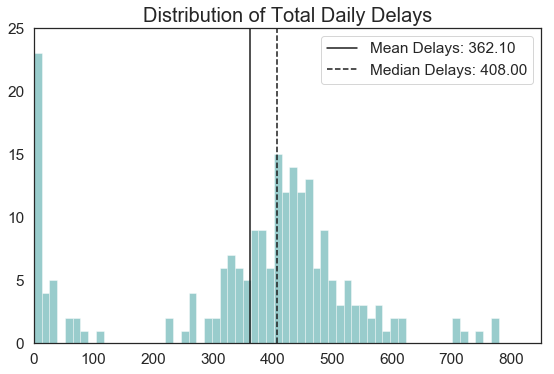

In [157]:
# Set Style of Histogram
mean = grid_search_daily['delay_count'].mean()
median = grid_search_daily['delay_count'].median()
stdev = grid_search_daily['delay_count'].std()

plt.figure(figsize=(8,5.5))
sns.set(font_scale=1.4, style='white')
ax = sns.distplot(grid_search_daily['delay_count'], kde=False, color='teal', bins=60)
    
# Set Label Names and Label Font
ax.set(xlabel='', ylabel='', ylim=(0,25), xlim=(0,850))
ax.set_title('Distribution of Total Daily Delays', fontsize=20)
    
# Add Vertical Lines and Legend
axv1 = ax.axvline(mean, label='Mean %s: %4.2f'%('Delays', mean), color='k')
axv2 = ax.axvline(median, label='Median %s: %4.2f'%('Delays', median), linestyle='--', color='k')
ax.legend()
    
# Finalize the plot

plt.tight_layout(h_pad=2)
print('Standard Deviation: %.2f'%grid_search_daily['delay_count'].std())
print('Min: %.2f'%grid_search_daily['delay_count'].min())
print('Max: %.2f'%grid_search_daily['delay_count'].max())

-----
## Step-forward Cross Validation of Time Series
Results from Grid Search Time Series 
1. (0, 0, 1), (1, 0, 0, 0), 'c' 160.64728512969418
2. (1, 1, 0), (1, 0, 1, 0), 'n' 160.9671913938127

In [29]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [30]:
my_parameters = [(0,0,1), (1,0,0,0), 'c']
predictions = list()
# split dataset
# train will return all historical values up except the 100 last in test
train, test = grid_search_daily.delay_count[:-71], grid_search_daily.delay_count[-71:]

# seed history with training dataset
history = [x for x in train]
actual = []
date = []
order, sorder, trend = my_parameters

# step over each time-step in the test set
for i in range(len(test)):
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, 
                trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    history.append(test[i])
    actual.append(test[i])
    date.append(test.index[i])
    predictions.append(yhat[0])
predicted_values = pd.DataFrame(data={'actual':actual,'predictions':predictions,'date':date}, 
                                columns=['actual', 'predictions','date'])

print(predicted_values.head(15))

predicted_values['difference_squared']=(predicted_values['predictions']-predicted_values['actual'])**2
predicted_values['absolute_error'] = np.sqrt(predicted_values['difference_squared'])
predicted_values['Day-of-Week'] = predicted_values['date'].apply(lambda x: x.day_name())
predicted_values['month'] = predicted_values['date'].apply(lambda x: x.month_name())
print('Root Mean Squared Error: %.3f'%np.sqrt(predicted_values['difference_squared'].mean()))



    actual  predictions       date
0    425.0   406.365357 2018-03-20
1      0.0   396.043018 2018-03-21
2    543.0   222.018953 2018-03-22
3    399.0   408.689210 2018-03-23
4    503.0   386.245434 2018-03-26
5    373.0   420.770325 2018-03-27
6    333.0   379.517413 2018-03-28
7    311.0   357.403803 2018-03-29
8      2.0   345.310257 2018-03-30
9     19.0   227.688509 2018-04-02
10     7.0   208.688836 2018-04-03
11     9.0   195.173758 2018-04-04
12    16.0   187.697879 2018-04-05
13    12.0   183.840992 2018-04-06
14   618.0   176.201202 2018-04-09
Root Mean Squared Error: 160.647


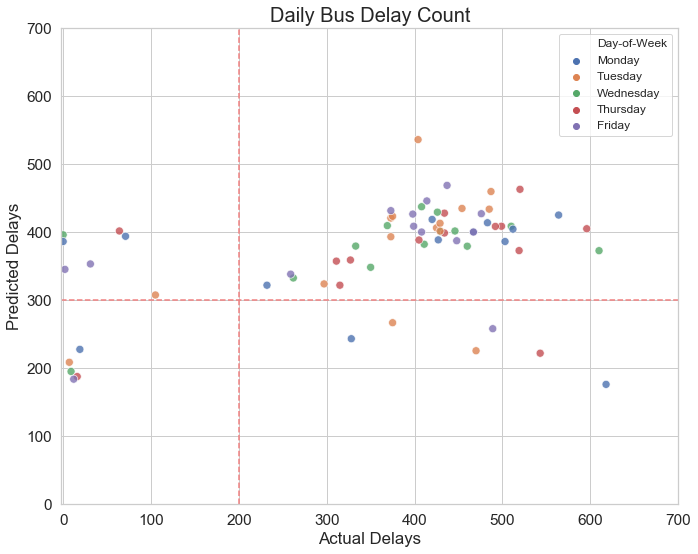

In [220]:

plt.figure(figsize=(10,8))
sns.set(font_scale=1.4, style='whitegrid')
ax = sns.scatterplot(data=predicted_values, x='actual', y='predictions', s=65, alpha=.8,
                     hue='Day-of-Week', hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
 
ax.set(xlabel='Actual Delays', 
       ylabel='Predicted Delays', 
       xlim=(-2,700),
       ylim=(0,700))
ax.set_title(label='Daily Bus Delay Count', fontsize=20)
ax.axvline(x=200,linestyle='--',c='lightcoral', linewidth=1.5)
ax.axhline(y=300,linestyle='--',c='lightcoral', linewidth=1.5)
plt.legend(loc='upper right', fontsize=12, title='')
plt.tight_layout()

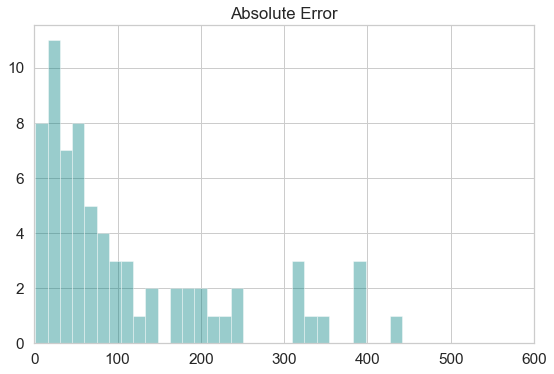

In [79]:
# Look at Absolute Error
plt.figure(figsize=(8,5.5))
sns.set(font_scale=1.4, style='whitegrid')

ax = sns.distplot(predicted_values['absolute_error'], kde=False, bins=30,
                 color='teal')
ax.set(xlabel='', ylabel='', xlim=(-0.5,600))
ax.set_title(label='Absolute Error')

plt.tight_layout()


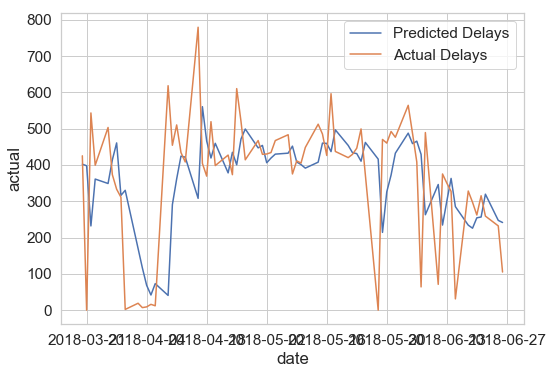

In [374]:
plt.figure(figsize=(8,5.5))
sns.set(font_scale=1.4, style='whitegrid')
ax1 = sns.relplot(data=predicted_values, x='date', y='predictions',hue=['predictins','actual'], label='Predicted Delays', sharex=True)
ax2 = sns.relplot(data=predicted_values, x='date', y='actual', label= 'Actual Delays')
plt.legend()
#ax1.set(xlabel='Actual Delays', ylabel='Predicted Delays', xlim=(-1,800))
#ax1.set_title(label='Bus Delay Count Scatter Plot')
plt.tight_layout()

In [125]:
# assign the hyperparameters
# example = [(p,d,q), (P,D,Q,m), t]

# define model
model = SARIMAX(endog=history, order=(1,0,1), seasonal_order=(0,0,1,5), trend='n', 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(history), len(history))

In [297]:
np.std(grid_search_daily.delay_count)

182.43948034519994

### Attempt at incorporating Exogenous Features

In [368]:
#grid_search_daily = pd.get_dummies(grid_search_daily, columns=['day'])
# Load your dataset
endog = grid_search_daily['delay_count']
exog = grid_search_daily[['day_Friday', 'day_Monday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday']]

mod_sarimax = sm.tsa.SARIMAX(endog=grid_search_daily['delay_count'], order=(1,0,1),
                             seasonal_order=(1,0,0,5), trend='n',
                             exog=exog   )
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())


                                 Statespace Model Results                                
Dep. Variable:                       delay_count   No. Observations:                  213
Model:             SARIMAX(1, 0, 1)x(1, 0, 0, 5)   Log Likelihood               -1383.144
Date:                           Mon, 18 Feb 2019   AIC                           2784.288
Time:                                   09:43:52   BIC                           2814.540
Sample:                               09-01-2017   HQIC                          2796.514
                                    - 06-26-2018                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
day_Friday      320.7913     34.384      9.330      0.000     253.399     388.184
day_Monday      393.1632     27.44

In [75]:
# seed history with training dataset
history = [x for x in train.delay_count]
actual = []
predictions = []
order, sorder, trend = my_parameters
exog =  train[['day_Friday', 'day_Monday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday']]
# step over each time-step in the test set
for i in range(len(test)):
    # define model
    model = SARIMAX(endog=train['delay_count'], order=order, seasonal_order=sorder, 
                    trend=trend, enforce_stationarity=False, enforce_invertibility=False,
                    exog=train[['day_Friday', 'day_Monday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']]
                   )
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(train['delay_count'])-1)
    #history.append(test.iloc[i,0])
    actual.append(test.iloc[i,0])
    train.append(test.iloc[i,:])
    predictions.append(yhat[0])
predicted_values = pd.DataFrame(data={'actual':actual,'predictions':predictions}, 
                                 columns=['actual', 'predictions'])
print(predicted_values.head(15))

### Grid Search Tuning SARIMA Hyperparameters
Source: [How to Grid Search SARIMA Hyperparameters for Time Series Forecasting in Python](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/), Jason Brownies, October 2018

In [76]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, 
                    trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1]
    d_params = [0, 1]
    q_params = [0, 1]
    t_params = ['n','c','t','ct']
    P_params = [0, 1]
    D_params = [0, 1]
    Q_params = [0, 1]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

if __name__ == '__main__':
    # define dataset
    data = grid_search_daily.delay_count#.values
    #print(data)
    # data split
    n_test = 71
    # model configs
    cfg_list = sarima_configs(seasonal=[0,5])
    # grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 5), 'n']] 406.270
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 406.270
 > Model[[(0, 0, 0), (0, 1, 0, 5), 'n']] 239.039
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 188.045
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 299.339
 > Model[[(0, 0, 0), (0, 0, 1, 5), 'n']] 314.253
 > Model[[(0, 0, 0), (1, 0, 0, 5), 'n']] 227.050
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 164.670
 > Model[[(0, 0, 0), (1, 1, 0, 5), 'n']] 206.044
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 175.821
 > Model[[(0, 0, 0), (0, 1, 1, 5), 'n']] 177.852
 > Model[[(0, 0, 0), (0, 0, 0, 5), 'c']] 175.821
 > Model[[(0, 0, 0), (1, 0, 1, 5), 'n']] 179.611
 > Model[[(0, 0, 0), (0, 0, 1, 5), 'c']] 179.343
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'c']] 169.648
 > Model[[(0, 0, 0), (1, 1, 1, 5), 'n']] 181.180
 > Model[[(0, 0, 0), (0, 1, 0, 5), 'c']] 240.050
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'c']] 163.590
 > Model[[(0, 0, 0), (1, 0, 0, 5), 'c']] 178.014
 > Model[[(0, 0, 0), (0, 1, 1, 5), 'c']] 179.448
 > Model[[(0, 0, 0),

 > Model[[(0, 1, 1), (0, 0, 0, 5), 't']] 166.357
 > Model[[(0, 1, 1), (1, 0, 1, 0), 'c']] 162.159
 > Model[[(0, 1, 1), (0, 0, 1, 5), 't']] 165.983
 > Model[[(0, 1, 1), (0, 1, 0, 5), 't']] 249.293
 > Model[[(0, 1, 1), (1, 1, 1, 5), 'c']] 167.738
 > Model[[(0, 1, 1), (0, 0, 1, 0), 't']] 170.768
 > Model[[(0, 1, 1), (1, 0, 0, 5), 't']] 165.486
 > Model[[(0, 1, 1), (1, 0, 0, 0), 't']] 165.919
 > Model[[(0, 1, 1), (0, 1, 1, 5), 't']] 169.237
 > Model[[(0, 1, 1), (1, 0, 1, 5), 't']] 166.087
 > Model[[(0, 1, 1), (1, 1, 0, 5), 't']] 199.735
 > Model[[(0, 1, 1), (1, 0, 1, 0), 't']] 163.071
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'ct']] 166.658
 > Model[[(0, 1, 1), (0, 0, 0, 5), 'ct']] 166.658
 > Model[[(0, 1, 1), (0, 1, 0, 5), 'ct']] 250.496
 > Model[[(0, 1, 1), (0, 0, 1, 5), 'ct']] 166.644
 > Model[[(0, 1, 1), (1, 1, 1, 5), 't']] 168.607
 > Model[[(0, 1, 1), (1, 0, 0, 5), 'ct']] 165.899
 > Model[[(0, 1, 1), (0, 0, 1, 0), 'ct']] 173.973
 > Model[[(0, 1, 1), (1, 0, 0, 0), 'ct']] 167.136
 > Model[[(0,

 > Model[[(1, 1, 1), (0, 0, 0, 0), 'n']] 163.614
 > Model[[(1, 1, 0), (1, 0, 1, 0), 'ct']] 164.575
 > Model[[(1, 1, 1), (0, 0, 0, 5), 'n']] 163.614
 > Model[[(1, 1, 1), (0, 1, 0, 5), 'n']] 229.748
 > Model[[(1, 1, 1), (0, 0, 1, 0), 'n']] 161.080
 > Model[[(1, 1, 1), (0, 0, 1, 5), 'n']] 165.201
 > Model[[(1, 1, 0), (1, 1, 1, 5), 'ct']] 179.041
 > Model[[(1, 1, 1), (1, 0, 0, 0), 'n']] 160.968
 > Model[[(1, 1, 1), (1, 0, 0, 5), 'n']] 165.054
 > Model[[(1, 1, 1), (0, 1, 1, 5), 'n']] 165.724
 > Model[[(1, 1, 1), (1, 0, 1, 0), 'n']] 171.965
 > Model[[(1, 1, 1), (1, 0, 1, 5), 'n']] 165.112
 > Model[[(1, 1, 1), (1, 1, 0, 5), 'n']] 188.752
 > Model[[(1, 1, 1), (0, 0, 0, 0), 'c']] 165.008
 > Model[[(1, 1, 1), (0, 0, 0, 5), 'c']] 165.008
 > Model[[(1, 1, 1), (1, 1, 1, 5), 'n']] 167.886
 > Model[[(1, 1, 1), (0, 0, 1, 0), 'c']] 162.175
 > Model[[(1, 1, 1), (0, 0, 1, 5), 'c']] 166.666
 > Model[[(1, 1, 1), (0, 1, 0, 5), 'c']] 231.397
 > Model[[(1, 1, 1), (1, 0, 0, 0), 'c']] 162.306
 > Model[[(1, 1, 1